# [作業目標]
- 使用 Day 12 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 12 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [99]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [92]:
app_train['AMT_INCOME_TOTAL'].replace({117000000: np.nan}, inplace = True)

In [18]:
# 檢視各資料型態
app_train.dtypes.value_counts()

float64     68
int64       40
object      13
int32        3
bool         1
category     1
category     1
dtype: int64

In [56]:
# 選取為數值的欄位
dtype_select = [np.dtype("float64"), np.dtype("int64"), np.dtype("int32")]
numeric_columns = list(app_train.columns[list(app_train.dtypes.isin(dtype_select))])

In [94]:
# 對各欄位做等寬分組，排除數值大多為重複的欄位，避免各組內都是同樣的值
cut_result = {}
for col_name in numeric_columns:
    if col_name != 'TARGET' and len(list(app_train[col_name].unique())) > 20:
        tmp_group = pd.cut(app_train[col_name], 5)
        tmp_df = pd.DataFrame({'TARGET': app_train['TARGET'], 'tmp_group': tmp_group})
        tmp_result = tmp_df.groupby('tmp_group').mean()
        cut_result["{}_GROUP".format(col_name)] = [tmp_result.iloc[:,0].max(), tmp_result.iloc[:,0].min()]
        
cut_result = pd.DataFrame(cut_result)
cut_result = cut_result.T.rename(columns={0:"max_mean", 1:"min_mean"})
cut_result['diff_mean'] = cut_result['max_mean'] - cut_result['min_mean']
cut_result.sort_values(by=['diff_mean'], ascending=False).head()

,max_mean,min_mean,diff_mean
OWN_CAR_AGE_GROUP,0.500000,0.068620,0.431380
AMT_REQ_CREDIT_BUREAU_YEAR_GROUP,0.250000,0.052632,0.197368
EXT_SOURCE_3_GROUP,0.220224,0.032568,0.187656
EXT_SOURCE_2_GROUP,0.199875,0.035444,0.164432
EXT_SOURCE_1_GROUP,0.180216,0.026954,0.153262


In [74]:
# 對各欄位做等頻分組，若有欄位數值大多重複導致各百分位的值重複則排除
qcut_result = {}
for col_name in numeric_columns:
    q5 = [np.percentile(app_train[col_name].dropna(), q = i) for i in [0, 20, 40, 60, 80, 100]]
    if col_name != 'TARGET' and len(set(q5)) == 6:
        tmp_group = pd.qcut(app_train[col_name], 5)
        tmp_df = pd.DataFrame({'TARGET': app_train['TARGET'], 'tmp_group': tmp_group})
        tmp_result = tmp_df.groupby('tmp_group').mean()
        qcut_result["{}_GROUP".format(col_name)] = [tmp_result.iloc[:,0].max(), tmp_result.iloc[:,0].min()]
        
qcut_result = pd.DataFrame(qcut_result)
qcut_result = qcut_result.T.rename(columns={0:"max_mean", 1:"min_mean"})
qcut_result['diff_mean'] = qcut_result['max_mean'] - qcut_result['min_mean']
qcut_result.sort_values(by=['diff_mean'], ascending=False).head()

,max_mean,min_mean,diff_mean
EXT_SOURCE_3_GROUP,0.163758,0.033763,0.129994
EXT_SOURCE_2_GROUP,0.152140,0.035870,0.116271
EXT_SOURCE_1_GROUP,0.145786,0.030417,0.115369
DAYS_BIRTH_AGE_GROUP,0.112824,0.051630,0.061193
DAYS_BIRTH_GROUP,0.112824,0.051630,0.061193


In [119]:
# 挑選兩邊都進排行的 EXT_SOURCE_3
cut_df = pd.DataFrame({
    'TARGET': app_train['TARGET'],
    'EXT_SOURCE_3': app_train['EXT_SOURCE_3'],
    'EXT_SOURCE_3_GROUP': pd.cut(app_train['EXT_SOURCE_3'], 5)})
cut_result = cut_df.groupby(['EXT_SOURCE_3_GROUP','TARGET']).count().sort_index().reset_index()
cut_result

,EXT_SOURCE_3_GROUP,TARGET,EXT_SOURCE_3
0,"(-0.000368, 0.18]",0,12485
1,"(-0.000368, 0.18]",1,3526
2,"(0.18, 0.359]",0,36281
3,"(0.18, 0.359]",1,5398
4,"(0.359, 0.538]",0,61284
5,"(0.359, 0.538]",1,5058
6,"(0.538, 0.717]",0,80276
7,"(0.538, 0.717]",1,3918
8,"(0.717, 0.896]",0,37072
9,"(0.717, 0.896]",1,1248


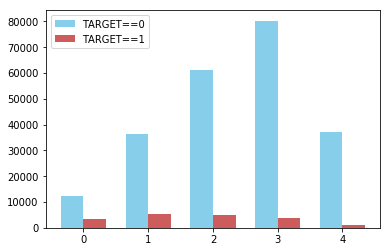

In [122]:
ind = np.arange(5)
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind-width/2, cut_result.loc[cut_result.TARGET==0, 'EXT_SOURCE_3'], width, color='SkyBlue', label='TARGET==0')
ax.bar(ind+width/2, cut_result.loc[cut_result.TARGET==1, 'EXT_SOURCE_3'], width, color='IndianRed', label='TARGET==1')
ax.legend()
plt.show()

In [123]:
qcut_df = pd.DataFrame({
    'TARGET': app_train['TARGET'],
    'EXT_SOURCE_3': app_train['EXT_SOURCE_3'],
    'EXT_SOURCE_3_GROUP': pd.qcut(app_train['EXT_SOURCE_3'], 5)})
qcut_result = qcut_df.groupby(['EXT_SOURCE_3_GROUP','TARGET']).count().sort_index().reset_index()
qcut_result

,EXT_SOURCE_3_GROUP,TARGET,EXT_SOURCE_3
0,"(-0.000473, 0.33]",0,41348
1,"(-0.000473, 0.33]",1,8097
2,"(0.33, 0.476]",0,45393
3,"(0.33, 0.476]",1,4353
4,"(0.476, 0.592]",0,46727
5,"(0.476, 0.592]",1,2851
6,"(0.592, 0.694]",0,47254
7,"(0.592, 0.694]",1,2216
8,"(0.694, 0.896]",0,46676
9,"(0.694, 0.896]",1,1631


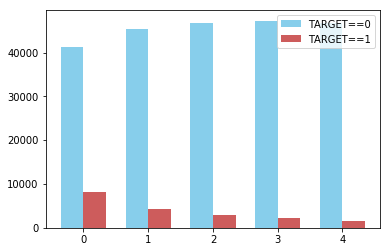

In [124]:
ind = np.arange(5)
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind-width/2, qcut_result.loc[qcut_result.TARGET==0, 'EXT_SOURCE_3'], width, color='SkyBlue', label='TARGET==0')
ax.bar(ind+width/2, qcut_result.loc[qcut_result.TARGET==1, 'EXT_SOURCE_3'], width, color='IndianRed', label='TARGET==1')
ax.legend()
plt.show()

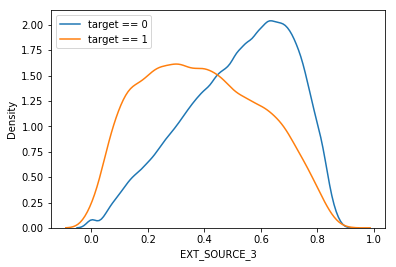

In [126]:
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'EXT_SOURCE_3'].dropna(), label = 'target == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'EXT_SOURCE_3'].dropna(), label = 'target == 1')
plt.xlabel('EXT_SOURCE_3')
plt.ylabel('Density')
plt.show()